In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from monodepth2.networks import ResnetEncoder, DepthDecoder  # Import network architectures

In [ ]:
!git clone https://github.com/nianticlabs/monodepth2.git
%cd monodepth2

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180 (from 1)
Receiving objects: 100% (180/180), 10.27 MiB | 31.67 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/monodepth2/monodepth2


In [ ]:
import os
os.listdir("models/")

['depth.pth', 'pose.pth', 'encoder.pth', 'pose_encoder.pth']

In [ ]:
!wget https://github.com/nianticlabs/monodepth2/releases/download/v1.0/mono+stereo_1024x320.zip

!unzip /content/mono+stereo_1024x320.zip -d models/

Archive:  /content/mono+stereo_1024x320.zip
replace models/depth.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace models/encoder.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace models/pose.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace models/pose_encoder.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


<ipython-input-39-104fc06c44ec>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict_enc = torch.load(encoder_path, map_location=device)
<ipython-input-39-104fc06c4

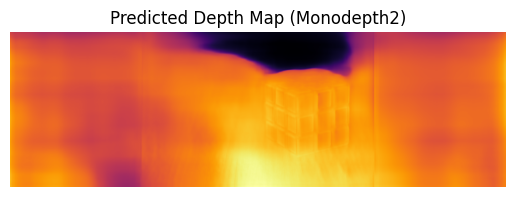

True

In [ ]:

def predict_depth(image_path, model_path="models"):
    """
    Use Monodepth2 to predict a depth map for a given image.

    Parameters:
        image_path (str): Path to the input image.
        model_path (str): Path to the Monodepth2 model directory.

    Returns:
        depth_map (numpy.ndarray): Predicted depth map.
        original_size (tuple): Original dimensions of the input image (width, height).
    """
    # Load the pretrained encoder and decoder
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize encoder and load its weights
    encoder = ResnetEncoder(18, False)  # ResNet18 encoder
    encoder_path = os.path.join(model_path, "encoder.pth")
    loaded_dict_enc = torch.load(encoder_path, map_location=device)
    encoder.load_state_dict({k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()})
    encoder.to(device)
    encoder.eval()

    # Initialize decoder and load its weights
    decoder = DepthDecoder(
        num_ch_enc=encoder.num_ch_enc, scales=range(4)
    )  # Depth decoder with 4 output scales
    decoder_path = os.path.join(model_path, "depth.pth")
    loaded_dict_dec = torch.load(decoder_path, map_location=device)
    decoder.load_state_dict(loaded_dict_dec)
    decoder.to(device)
    decoder.eval()

    # Preprocess the input image
    input_image = cv2.imread(image_path)
    if input_image is None:
        raise ValueError(f"Image not found: {image_path}")
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    original_height, original_width = input_image.shape[:2]
    input_image = cv2.resize(input_image, (1024, 320))  # Resize to model's expected input size
    input_image_tensor = transforms.ToTensor()(input_image).unsqueeze(0).to(device)

    # Run inference
    with torch.no_grad():
        features = encoder(input_image_tensor)  # Extract features with encoder
        outputs = decoder(features)            # Predict depth with decoder

    # Extract the depth map from the outputs
    depth_map = outputs[("disp", 0)].squeeze().cpu().numpy()

    # Normalize the depth map for visualization
    depth_map_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

    return depth_map_normalized, (original_width, original_height)

# Specify the path to the image and models
image_path = "/content/cube_1024x320.jpg"  # Replace with your image path
model_path = "models"

# Predict the depth
depth_map, original_size = predict_depth(image_path, model_path)

# Display the depth map
plt.imshow(depth_map, cmap="inferno")
plt.title("Predicted Depth Map (Monodepth2)")
plt.axis("off")
plt.show()

# Save the depth map
depth_map_resized = cv2.resize(depth_map, original_size)  # Resize to original dimensions
cv2.imwrite("depth_map.png", (depth_map_resized * 255).astype(np.uint8))

Detected 4 contours.


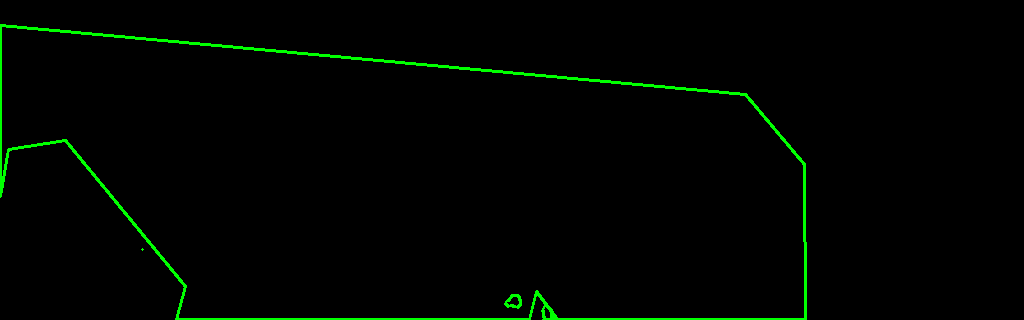

In [ ]:
from google.colab.patches import cv2_imshow  # For displaying images in Colab

def analyze_depth_map(depth_map):
    """
    Analyze the depth map by detecting contours, approximating polygons,
    and identifying convexities/concavities.

    Parameters:
        depth_map (numpy.ndarray): Input depth map.

    Returns:
        contours (list): Contours detected in the depth map.
        approx_polygons (list): Approximated polygons for each contour.
        contour_types (list): Types of contours ('hole' or 'object').
    """
    # Normalize the depth map to [0, 1]
    depth_map_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

    # Convert depth map to binary using thresholding
    threshold_value = 0.5  # Adjust this threshold based on your application
    _, depth_map_binary = cv2.threshold(depth_map_normalized, threshold_value, 1, cv2.THRESH_BINARY)
    depth_map_binary = depth_map_binary.astype(np.uint8)

    # Find contours
    contours, hierarchy = cv2.findContours(depth_map_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    approx_polygons = []  # Store approximated polygons
    contour_types = []    # Store types of contours ('hole' or 'object')

    for contour in contours:
        # Approximate polygon for the contour
        epsilon = 0.01 * cv2.arcLength(contour, True)  # Adjust epsilon multiplier as needed
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approx_polygons.append(approx)

        # Determine contour type based on area
        area = cv2.contourArea(contour)
        contour_types.append('hole' if area < 0 else 'object')

    return contours, approx_polygons, contour_types

# Example usage
contours, approx_polygons, contour_types = analyze_depth_map(depth_map)

print(f"Detected {len(contours)} contours.")


def display_approximated_polygons(depth_map):
    """
    Display approximated polygons on a depth map or binary image.

    Parameters:
        depth_map (numpy.ndarray): Input depth map.
    """
    # Normalize the depth map to [0, 1]
    depth_map_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

    # Convert depth map to binary using thresholding
    threshold_value = 0.5  # Adjust threshold based on your application
    _, depth_map_binary = cv2.threshold(depth_map_normalized, threshold_value, 1, cv2.THRESH_BINARY)
    depth_map_binary = (depth_map_binary * 255).astype(np.uint8)  # Convert to 8-bit format

    # Find contours
    contours, _ = cv2.findContours(depth_map_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create an image to visualize the polygons
    visualization_image = np.zeros_like(depth_map_binary)
    visualization_image = cv2.cvtColor(visualization_image, cv2.COLOR_GRAY2BGR)

    for contour in contours:
        # Approximate the polygon for each contour
        epsilon = 0.01 * cv2.arcLength(contour, True)  # Adjust epsilon as needed
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Draw the approximated polygon on the visualization image
        cv2.drawContours(visualization_image, [approx], -1, (0, 255, 0), 2)  # Green color for polygons

    # Display the image with approximated polygons
    cv2_imshow(visualization_image)

# Example usage
display_approximated_polygons(depth_map)
